In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import os
print(os.listdir("D:/Projects/Sentiment_Analysis/input"))
import warnings
warnings.filterwarnings('ignore')

['IMDB Dataset.csv']


In [34]:
imdb_data=pd.read_csv("D:/Projects/Sentiment_Analysis/input/IMDB Dataset.csv")
imdb_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [35]:
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [36]:
#sentiment count
imdb_data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [37]:
train_reviews=imdb_data.review[:40000]
train_sentiment=imdb_data.sentiment[:40000]
test_reviews=imdb_data.review[40000:]
test_sentiment=imdb_data.sentiment[40000:]
print(train_reviews.shape)
print(train_sentiment.shape)
print(test_reviews.shape)
print(test_sentiment.shape)

(40000,)
(40000,)
(10000,)
(10000,)


Text Normalization

In [38]:
#Tokenization of words
tokenizer=ToktokTokenizer()
stopword_list=nltk.corpus.stopwords.words('english')

Remove HTML strips and noise text

In [39]:
def strip_html(text):
    soup=BeautifulSoup(text,'html.parser')
    return soup.get_text()

#removing square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    text=strip_html(text)
    text=remove_between_square_brackets(text)
    return text

imdb_data['review']=imdb_data['review'].apply(denoise_text)

Remove Special Characters

In [40]:
def remove_special_characters(text):
    pattern=r'[^a-zA-Z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

Lemmatization


In [41]:
def simple_lemmatization(text):
    lm=WordNetLemmatizer()
    text=' '.join(lm.lemmatize(word) for word in text.split())
    return text

imdb_data['review']=imdb_data['review'].apply(simple_lemmatization)

Stop Word Removal

In [42]:
stop=list(stopwords.words('english'))
print(stop)

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize ( text )
    if is_lower_case:
        filtered_tokens=[token for token in tokens if token not in stopword_list ]
    else:
        filtered_tokens=[token for token in tokens if token.lower() not in stopword_list ]  
    filtered_tokens=' '.join(filtered_tokens)      
    return filtered_tokens

imdb_data['review']=imdb_data['review'].apply(remove_stopwords)    

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

BoW creates a vocabulary of all unique words in your dataset, and then represents each document (review) as a vector:

Each position in the vector = a word in the vocabulary

Value = how many times that word appears in the document

In [43]:
cv=CountVectorizer(max_df=0.9,min_df=2,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(test_reviews)
print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (40000, 1370393)
BOW_cv_test: (10000, 1370393)


TF-IDF stands for:

TF = Term Frequency → How often a word appears in a document.

IDF = Inverse Document Frequency → How rare the word is across all documents.

In [44]:
tv=TfidfVectorizer(max_df=0.9,min_df=2,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(test_reviews)
print('TF_IDF_tv_train:',tv_train_reviews.shape)
print('TF_IDF_tv_test:',tv_test_reviews.shape)

TF_IDF_tv_train: (40000, 1370393)
TF_IDF_tv_test: (10000, 1370393)


Conversion of sentiment data to vector

In [45]:
#LabelBinarizer
lb=LabelBinarizer()
sentiment_data=lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)


(50000, 1)


Split the sentiment data

In [46]:
train_v_sentiments=sentiment_data[:40000]
test_v_sentiments=sentiment_data[40000:]
print(train_v_sentiments)
print(test_v_sentiments)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


Modelling the dataset
1) Logistic Regression --> Regularization(Adding Penalty to avoid overfitting)

In [47]:
lr=LogisticRegression(penalty='l2',C=1,max_iter=500,random_state=42)
#BOW MODEL
lr_Bow=lr.fit(cv_train_reviews,train_v_sentiments)
print(lr_Bow)
#tf-idf 
lr_tf_idf=lr.fit(tv_train_reviews,train_v_sentiments)
print(lr_tf_idf)

LogisticRegression(C=1, max_iter=500, random_state=42)
LogisticRegression(C=1, max_iter=500, random_state=42)


Prediction of LR model

In [48]:
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 1 0 0]
[0 0 0 ... 1 0 0]


Accuracy


In [49]:
lr_bow_accuracy=accuracy_score(test_v_sentiments,lr_bow_predict)
print(lr_bow_accuracy)
lr_tfidf_accuracy=accuracy_score(test_v_sentiments,lr_tfidf_predict)
print(lr_tfidf_accuracy)

0.8616
0.8988


Classification Report

In [50]:
#Classification report for bag of words 
lr_bow_report=classification_report(test_v_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_v_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.89      0.83      0.86      4993
    Negative       0.84      0.90      0.87      5007

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

              precision    recall  f1-score   support

    Positive       0.90      0.89      0.90      4993
    Negative       0.89      0.91      0.90      5007

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



Confusion Matrix

In [51]:
# Confusion matrix for Bag of Words model
cm_bow = confusion_matrix(test_v_sentiments, lr_bow_predict, labels=[0, 1])
print("Confusion Matrix (BoW):")
print(f"TN: {cm_bow[0][0]}, FP: {cm_bow[0][1]}")
print(f"FN: {cm_bow[1][0]}, TP: {cm_bow[1][1]}")

# Confusion matrix for TF-IDF model
cm_tfidf = confusion_matrix(test_v_sentiments, lr_tfidf_predict, labels=[0, 1])
print("\nConfusion Matrix (TF-IDF):")
print(f"TN: {cm_tfidf[0][0]}, FP: {cm_tfidf[0][1]}")
print(f"FN: {cm_tfidf[1][0]}, TP: {cm_tfidf[1][1]}")

Confusion Matrix (BoW):
TN: 4134, FP: 859
FN: 525, TP: 4482

Confusion Matrix (TF-IDF):
TN: 4455, FP: 538
FN: 474, TP: 4533


Stochastic Gradient Descent (SVM) --> svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)

In [52]:
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)
svm_bow=svm.fit(cv_train_reviews,train_v_sentiments)
print(svm_bow)
svm_tfidf=svm.fit(tv_train_reviews,train_v_sentiments)
print(svm_tfidf)

SGDClassifier(max_iter=500, random_state=42)
SGDClassifier(max_iter=500, random_state=42)


Prediction

In [53]:
svm_bow_predict=svm.predict(cv_test_reviews)
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_bow_predict)
print(svm_tfidf_predict)

[0 0 0 ... 1 0 0]
[0 0 0 ... 1 0 0]


Accuracy

In [54]:
svm_bow_accuracy=accuracy_score(test_v_sentiments,svm_bow_predict)
print(svm_bow_accuracy)
svm_tfidf_accuracy=accuracy_score(test_v_sentiments,svm_tfidf_predict)
print(svm_tfidf_accuracy)

0.8613
0.8996


Classification Report

In [55]:
cp_svm_bow=classification_report(test_v_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
print(cp_svm_bow)
cp_svm_tfidf=classification_report(test_v_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
print(cp_svm_tfidf)

              precision    recall  f1-score   support

    Positive       0.91      0.81      0.85      4993
    Negative       0.83      0.92      0.87      5007

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000

              precision    recall  f1-score   support

    Positive       0.91      0.81      0.85      4993
    Negative       0.83      0.92      0.87      5007

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



Confusion Matrix

In [56]:
cm_bow_svm = confusion_matrix(test_v_sentiments, svm_bow_predict, labels=[0, 1])
print("Confusion Matrix (BoW):")
print(f"TN: {cm_bow_svm[0][0]}, FP: {cm_bow_svm[0][1]}")
print(f"FN: {cm_bow_svm[1][0]}, TP: {cm_bow_svm[1][1]}")

# Confusion matrix for TF-IDF model
cm_tfidf_svm = confusion_matrix(test_v_sentiments, svm_bow_predict, labels=[0, 1])
print("\nConfusion Matrix (TF-IDF):")
print(f"TN: {cm_tfidf_svm[0][0]}, FP: {cm_tfidf_svm[0][1]}")
print(f"FN: {cm_tfidf_svm[1][0]}, TP: {cm_tfidf_svm[1][1]}")

Confusion Matrix (BoW):
TN: 4027, FP: 966
FN: 421, TP: 4586

Confusion Matrix (TF-IDF):
TN: 4027, FP: 966
FN: 421, TP: 4586


Multinomial Naive Bayes

In [57]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_v_sentiments)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_v_sentiments)
print(mnb_tfidf)

MultinomialNB()
MultinomialNB()


Prediction

In [58]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


Accuracy

In [59]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_v_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_v_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.8814
mnb_tfidf_score : 0.8957


Classification Report


In [60]:
#Classification report for bag of words 
mnb_bow_report=classification_report(test_v_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_v_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.85      0.92      0.89      4993
    Negative       0.91      0.84      0.88      5007

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

              precision    recall  f1-score   support

    Positive       0.89      0.91      0.90      4993
    Negative       0.91      0.88      0.89      5007

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



Confusion Matrix

In [61]:
cm_bow_mnb = confusion_matrix(test_v_sentiments, mnb_bow_predict, labels=[0, 1])
print("Confusion Matrix (BoW):")
print(f"TN: {cm_bow_mnb[0][0]}, FP: {cm_bow_mnb[0][1]}")
print(f"FN: {cm_bow_mnb[1][0]}, TP: {cm_bow_mnb[1][1]}")

# Confusion matrix for TF-IDF model
cm_tfidf_mnb = confusion_matrix(test_v_sentiments, mnb_bow_predict, labels=[0, 1])
print("\nConfusion Matrix (TF-IDF):")
print(f"TN: {cm_tfidf_mnb[0][0]}, FP: {cm_tfidf_mnb[0][1]}")
print(f"FN: {cm_tfidf_mnb[1][0]}, TP: {cm_tfidf_mnb[1][1]}")

Confusion Matrix (BoW):
TN: 4599, FP: 394
FN: 792, TP: 4215

Confusion Matrix (TF-IDF):
TN: 4599, FP: 394
FN: 792, TP: 4215


Word cloud for positive review words

<function matplotlib.pyplot.show(close=None, block=None)>

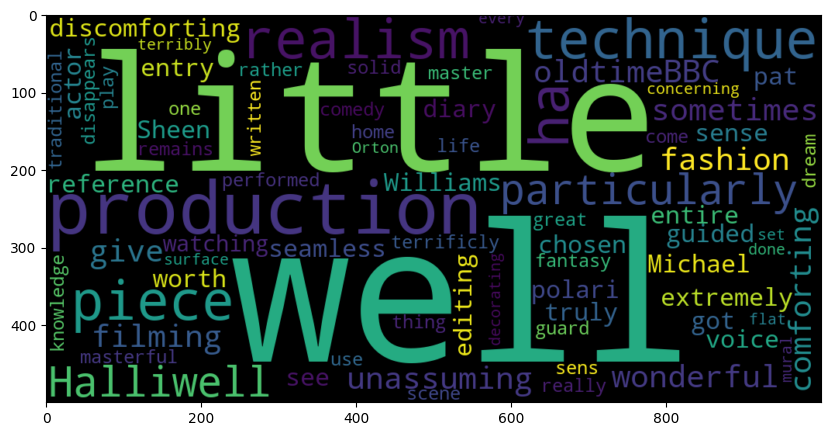

In [62]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=imdb_data.review[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

Word cloud for negative review words

<function matplotlib.pyplot.show(close=None, block=None)>

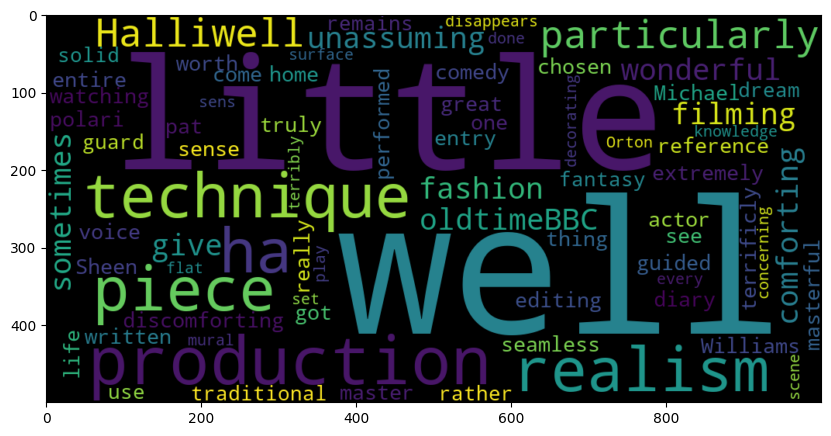

In [63]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=imdb_data.review[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

Saving the trained model

In [64]:
# Save the vectorizer (TF-IDF)
joblib.dump(cv, "D:/Projects/Sentiment_Analysis/Models/bow_vectorizer.pkl")
joblib.dump(tv, "D:/Projects/Sentiment_Analysis/Models/tfidf_vectorizer.pkl")

# Save the trained model
joblib.dump(lr_tf_idf, "D:/Projects/Sentiment_Analysis/Models/lr_tfidf_model.pkl")
joblib.dump(lr_Bow, "D:/Projects/Sentiment_Analysis/Models/lr_bow_model.pkl")

joblib.dump(svm_tfidf, "D:/Projects/Sentiment_Analysis/Models/svm_tfidf_model.pkl")
joblib.dump(svm_bow, "D:/Projects/Sentiment_Analysis/Models/svm_bow_model.pkl")

joblib.dump(mnb_tfidf, "D:/Projects/Sentiment_Analysis/Models/mnb_tfidf_model.pkl")
joblib.dump(mnb_bow, "D:/Projects/Sentiment_Analysis/Models/mnb_bow_model.pkl")


['D:/Projects/Sentiment_Analysis/Models/mnb_bow_model.pkl']